In [74]:
# Import packages

# Visualization packages:
library(ggplot2)
library(ggbeeswarm)
library(psych)

# Data manipulation: 
library(dplyr)
library(reshape2)


Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha




In [1]:
# Set data path
setwd("C:/Users/user/OneDrive - Erasmus University Rotterdam/Documents/01 Postgrad/02 Spring semester/06 Business Analytics for International Managers/rsm_data_analytics")

In [158]:
# Import the CSV file 
df <- read.csv("ebi_customers.csv")
head(df)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0


# 1: Data Pre-Processing

__1.1 Are there any outliers/anomaly in the data that need to be addressed?__

In [159]:
missing_values <- sum(is.na(df))
paste0("There are ",  missing_values, " missing values in the dataframe.")

[1] "There are 0 missing values in the dataframe."

In [123]:
numeric_variables <- names(df)[sapply(df, function(col) {
  is.numeric(col) && length(unique(col)) > 11 && !grepl("CustomerId", col)
})]
paste0(numeric_variables, " is a numeric variable.")

[1] "credit_score is a numeric variable."    
[2] "age is a numeric variable."             
[3] "balance is a numeric variable."         
[4] "estimated_salary is a numeric variable."

In [118]:
# Define a function to calculate outlier thresholds for a variable in a dataframe
outlier_thresholds <- function(df, variable, low_quantile=0.05, up_quantile=0.95){
  # Calculate the first quartile (lower quantile) of the variable
  quantile_one <- quantile(df[[variable]], low_quantile)
  # Calculate the third quartile (upper quantile) of the variable
  quantile_three <- quantile(df[[variable]], up_quantile)
  # Calculate the interquartile range of the variable
  interquantile_range <- quantile_three - quantile_one
  # Calculate the upper limit for outliers
  up_limit <- quantile_three + 1.5 * interquantile_range
  # Calculate the lower limit for outliers
  low_limit <- quantile_one - 1.5 * interquantile_range
  # Return the lower and upper limits as a vector
  return(c(low_limit, up_limit))
}

limits <- outlier_thresholds(df, age)
limits

In [ ]:
# Define a function to check for outliers in numeric columns of a dataframe
has_outliers <- function(dataframe, numeric_columns, plot=FALSE) {
  
  # Loop through each numeric column in the dataframe
  for (col in numeric_columns) {
    
    # Calculate the outlier limits for the column using the outlier_thresholds function
    limits <- outlier_thresholds(dataframe, col)
    low_limit <- limits[1]
    up_limit <- limits[2]
    
    # Check if the column has any values outside the outlier limits
    if (any(dataframe[[col]] > up_limit | dataframe[[col]] < low_limit)) {
      
      # If there are outliers, count them and print a message
      number_of_outliers <- sum(dataframe[[col]] > up_limit | dataframe[[col]] < low_limit)
      print(paste(col, ": ", number_of_outliers, "outliers"))
      
      # If the plot argument is true, create a boxplot of the column
      if (plot) {
        boxplot(dataframe[[col]], main = col)
      }
      
    } else {
      
      # If there are no outliers, set number_of_outliers to zero
      number_of_outliers <- 0
      
    }
  }
}

In [154]:
# Define a function to check for outliers in numeric columns of a dataframe
has_outliers <- function(dataframe, numeric_columns) {
  
  outlier_counts <- list() 
  # Loop through each numeric column in the dataframe
  for (col in numeric_columns) {
    # Calculate the outlier limits for the column using the outlier_thresholds function
    limits <- outlier_thresholds(dataframe, col)
    low_limit <- limits[1]
    up_limit <- limits[2]
    # Check if the column has any values outside the outlier limits
    if (any(dataframe[[col]] > up_limit | dataframe[[col]] < low_limit)) {
      # If there are outliers, count them and add outlier count to list
      number_of_outliers <- sum(dataframe[[col]] > up_limit | dataframe[[col]] < low_limit)
      outlier_counts[[col]] <- number_of_outliers 
      }
      
    else {
      outlier_counts[[col]] <- 0 
    }
  }
  return(outlier_counts)
}


In [155]:
for (var in numeric_variables) {
  outliers <- has_outliers(df, var)
  print(paste(var, "has", outliers, "outliers"))
}

[1] "credit_score has 0 outliers"
[1] "age has 0 outliers"
[1] "balance has 0 outliers"
[1] "estimated_salary has 0 outliers"


__1.2 Are there variables in the dataset that will not be used in the analysis? Remove them.__

In [160]:
# Drop customer_id column
df <- select(df, -customer_id)

__1.3 Are there categorical variables in the dataset? 
Should you convert those variables to numerical?__

In [163]:
#One-hot encoding of gender variable
gender_encoded <- model.matrix(~ gender - 1, data = df)
new_df <- cbind(df, gender_encoded)

#One-hot encoding of country variable
country_encoded <- model.matrix(~ country - 1, data = df)
new_df <- cbind(new_df, country_encoded)

#Drop redundant columns (Verify if droping genderMale and countrySpain is right?)
new_df <- select(new_df, -gender, -genderMale, -country, -countrySpain)
head(new_df)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,genderFemale,countryFrance,countryGermany
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,619,42,2,0.00,1,1,1,101348.88,1,1,1,0
2,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,0,0
6,822,50,7,0.00,2,1,1,10062.80,0,0,1,0


# 2: Exploratory Data Analysis

__2.1: What is the overall rate of customer churn in the dataset?__

In [164]:
churn_rate <- mean(df$churn)
churn_rate_pct <-paste0(round(churn_rate*100,2),"%")
cat("The overall rate of customer churn is:",churn_rate_pct)

The overall rate of customer churn is: 20.36%

__2.2: How does the rate of customer churn vary by demographic variables such as age, gender, etc.? How does it vary across the countries?__

In [165]:
churn_rate_by_gender <- aggregate(churn ~ gender, df, function(x) round(100 * sum(x) / length(x), 2))
                                  
churn_rate_by_country <- aggregate(churn ~ country, df, function(x) round(100 * sum(x) / length(x), 2))
                                  
cat("Churn rate by gender:\n")
print(churn_rate_by_gender)
cat("\n")                         
cat("Churn rate by country:\n")
print(churn_rate_by_country)

Churn rate by gender:
  gender churn
1 Female 24.98
2   Male 16.49

Churn rate by country:
  country churn
1  France 16.15
2 Germany 32.33
3   Spain 16.70


Women have, on average, a higher churn rate then men. Germans have, on average, a higher churn rate than French and Spanish.

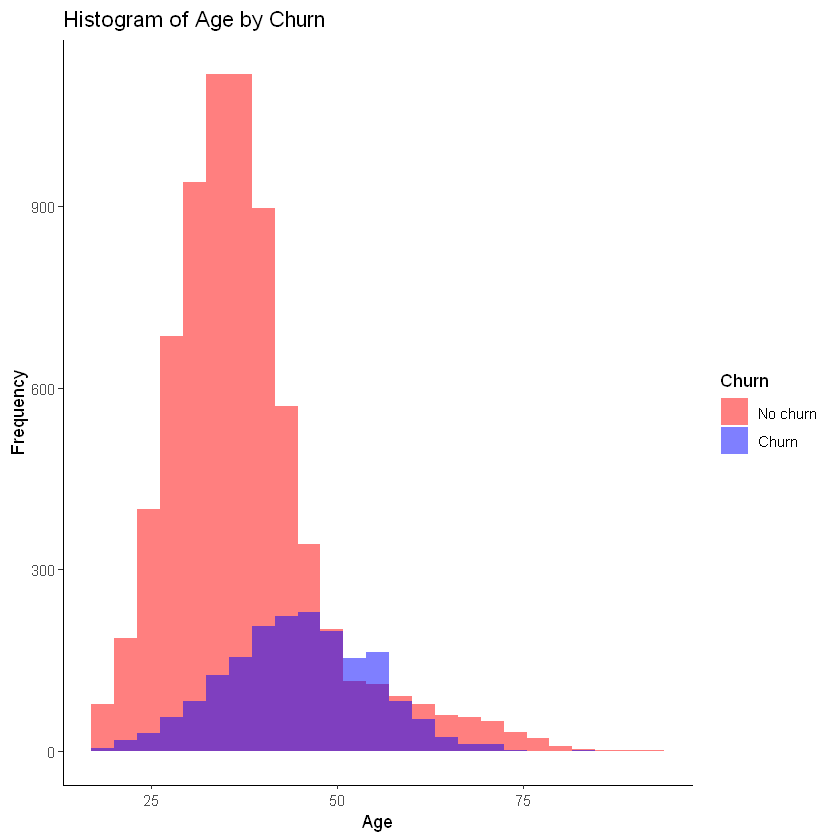

In [166]:
# Plot age distribution by churn vs. no-churn
ggplot(df, aes(x = age, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Age by Churn", x = "Age", y = "Frequency", fill = "Churn") +
  theme_classic()

In [167]:
age_brackets <- cut(df$age, breaks = seq(15, 95, by = 5), right = FALSE)
churn_rate_by_age_bracket <- aggregate(churn ~ age_brackets, df, function(x) round(100 * sum(x) / length(x), 2))
cat("Churn rate by country:\n")
print(churn_rate_by_age_bracket)

Churn rate by country:
   age_brackets churn
1       [15,20)  6.52
2       [20,25)  9.24
3       [25,30)  6.89
4       [30,35)  8.46
5       [35,40) 12.97
6       [40,45) 24.17
7       [45,50) 42.84
8       [50,55) 56.28
9       [55,60) 54.55
10      [60,65) 41.44
11      [65,70) 21.37
12      [70,75) 15.91
13      [75,80)  0.00
14      [80,85) 11.11
15      [85,90)  0.00
16      [90,95)  0.00


Customers in the age group between 45 and 65 have the highest churn rate. 

__2.3: Report interesting patterns that you find in the dataset.__

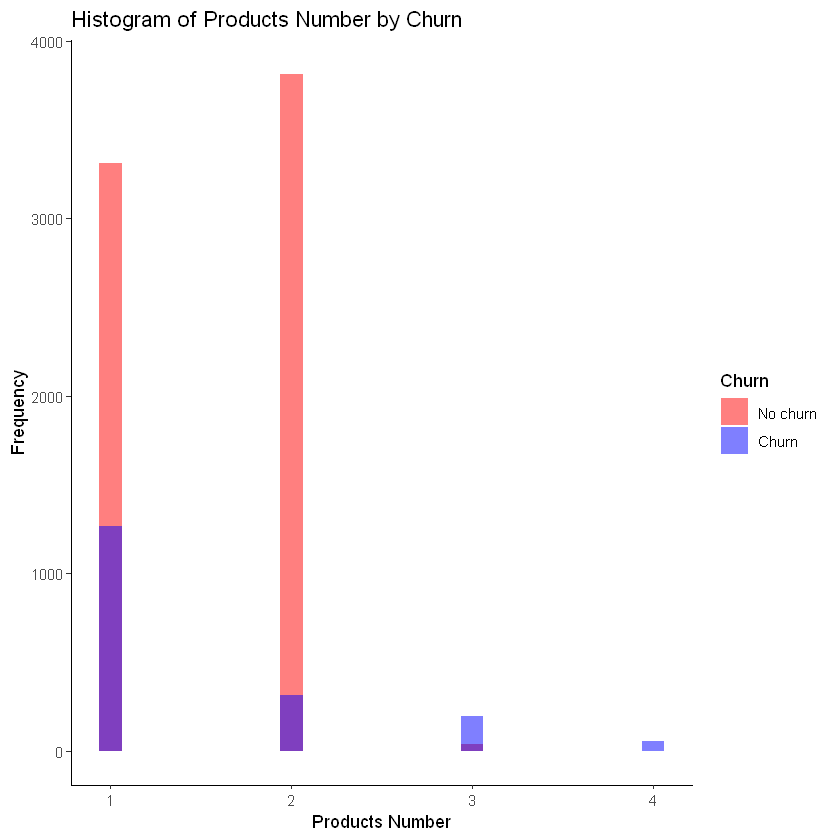

In [168]:
# Plot product number distribution by churn vs. no-churn
ggplot(df, aes(x = products_number, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Products Number by Churn", x = "Products Number", y = "Frequency", fill = "Churn") +
  theme_classic()

In [169]:
# Separate out ages for two groups
products_churn <- df$products_number[df$churn == 1]
products_no_churn <- df$products_number[df$churn == 0]

# Calculate difference in mean and median
mean_diff_products <- mean(products_no_churn) - mean(products_churn)
median_diff_products <- median(products_no_churn) - median(products_churn)
cat("Mean diff in number of products:", mean_diff_products, "\n")
cat("Median diff in number of products:", median_diff_products, "\n")

# Run t-test
ttest <- t.test(products_churn, products_no_churn)
pval <- ttest$p.value
cat("P-value for number of products vs churn:", pval, "\n")

Mean diff in number of products: 0.0712257 
Median diff in number of products: 1 
P-value for number of products vs churn: 0.0002905912 


There seems to be a statistically significant relationship between the number of products and churn. Customers that have a higher number of products are less likely to churn. The fact, however, that customers with four products have all churned goes against this observation. 

In [170]:
subset(df, products_number == 4)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
65,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1
1115,628,France,Female,46,1,46870.43,4,1,0,31272.14,1
1307,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1
1324,596,Spain,Male,30,6,121345.88,4,1,0,41921.75,1
1519,792,France,Male,50,9,0.00,4,1,1,194700.81,1
1669,640,Germany,Male,39,9,131607.28,4,0,1,6981.43,1
1895,704,France,Male,32,7,127785.17,4,0,0,184464.70,1
1962,773,Germany,Male,47,2,118079.47,4,1,1,143007.49,1


In [171]:
# create contingency table to test relationship between churn and membership status
table_active_member <- table(df$active_member, df$churn)
rownames(table_active_member) <- c("Non-Active Member", "Active Member")
colnames(table_active_member) <- c("Not Churned", "Churned")

# run chi-squared test and print p-value
test <- chisq.test(table_active_member)
pval <- test$p.value
print(pval)

# print expected values
expected <- test$expected
rownames(expected) <- rownames(table_active_member)
colnames(expected) <- colnames(table_active_member)
print(expected)

[1] 1.654353e-46
                   
                    Not Churned  Churned
  Non-Active Member    3478.869 889.1307
  Active Member        3689.131 942.8693


There is a statistically significant relationship between membership status and churn. Non-active members are more likely to churn than active members. 

__2.4: Further non-significant findings:__

In [172]:
# create contingency table to test relationship between churn and credit card ownership
table_credit_card <- table(df$credit_card, df$churn)

# run chi-squared test and print p-value
test <- chisq.test(table_credit_card)
pval <- test$p.value
print(pval)

# print expected values
expected <- test$expected
print(expected)

[1] 0.5254901
   
          0       1
  0 2114.56  540.44
  1 5053.44 1291.56


No statistically significant relationship between churn rate and credit card ownership as p-value is not leas than the significance level of 5%

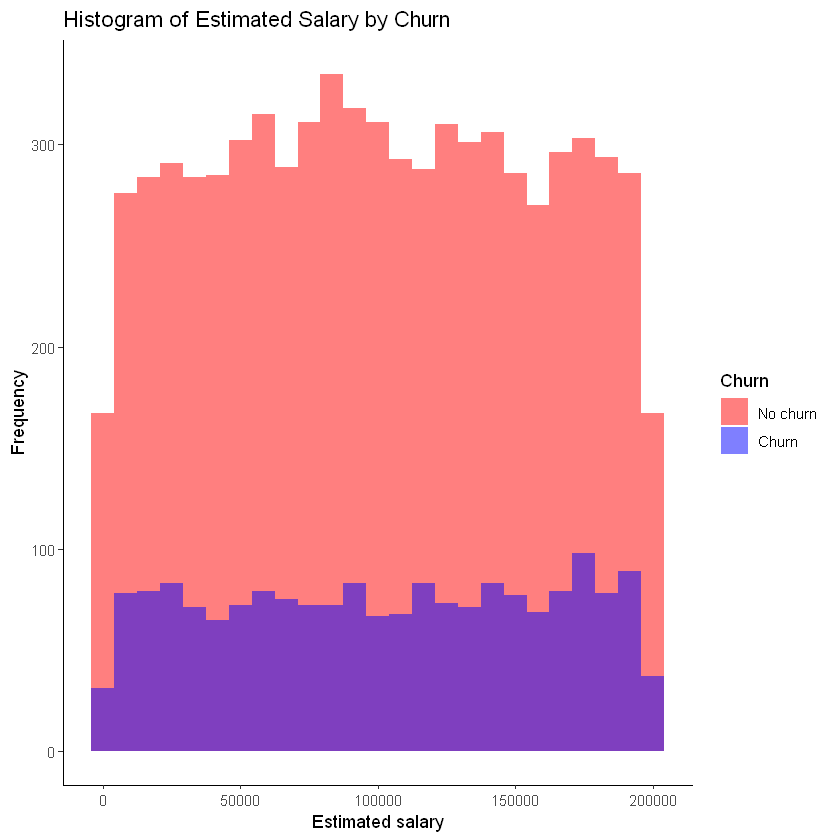

In [173]:
# Plot estimated salary distribution by churn vs. no-churn
ggplot(df, aes(x = estimated_salary, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Estimated Salary by Churn", x = "Estimated salary", y = "Frequency", fill = "Churn") +
  theme_classic()

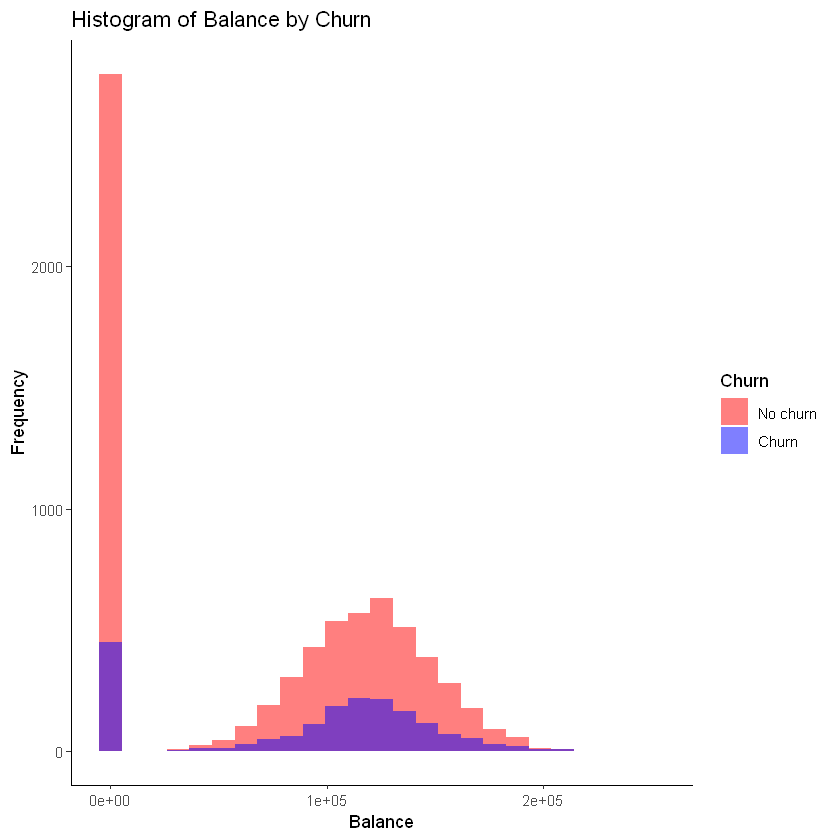

In [174]:
# Plot balance distribution by churn vs. no-churn
ggplot(df, aes(x = balance, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Balance by Churn", x = "Balance", y = "Frequency", fill = "Churn") +
  theme_classic()

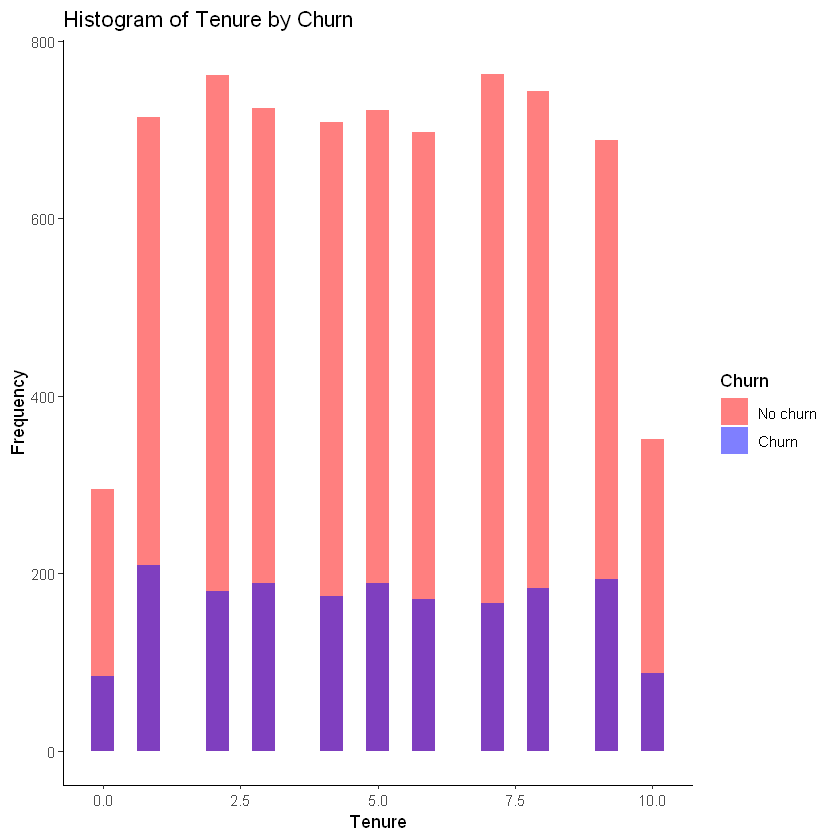

In [175]:
# Plot tenure distribution by churn vs. no-churn
ggplot(df, aes(x = tenure, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Tenure by Churn", x = "Tenure", y = "Frequency", fill = "Churn") +
  theme_classic()

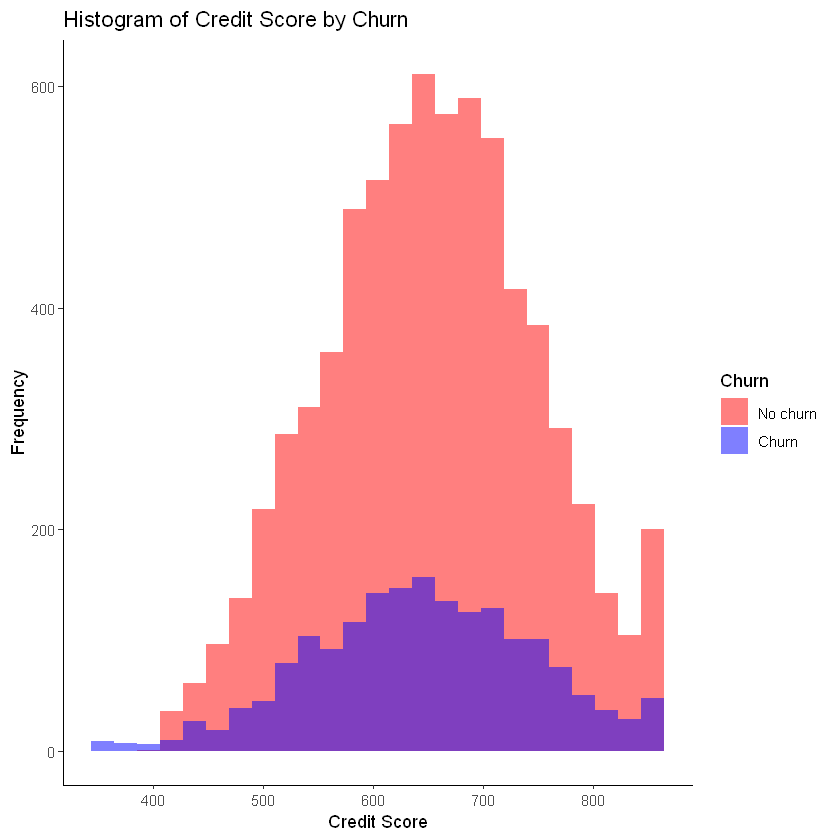

In [176]:
# Plot credit score distribution by churn vs. no-churn
ggplot(df, aes(x = credit_score, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Credit Score by Churn", x = "Credit Score", y = "Frequency", fill = "Churn") +
  theme_classic()

# 3: Model Building

Which variables are the strongest predictors of customer churn? 
How did you conclude that these are the strongest predictors? 
How do different model evaluation metrics (e.g., accuracy, precision, recall) vary for different models? 
Which model would you use for predicting customer churn?

In [98]:
r <- cor(df_new)
corr <- as.data.frame(r)
corr

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,genderFemale,countryFrance,countryGermany,countrySpain
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
customer_id,1.000000000,0.0053079006,0.009496867,-0.0148825539,-0.012418700,0.016971877,-0.014025130,0.001664965,0.015270681,-0.006247987,0.002641163,-0.004049210,-0.0030968582,0.007800240
credit_score,0.005307901,1.0000000000,-0.003964906,0.0008419418,0.006268382,0.012237879,-0.005458482,0.025651323,-0.001384293,-0.027093540,0.002856620,-0.008928067,0.0055375526,0.004779770
age,0.009496867,-0.0039649055,1.000000000,-0.0099968256,0.028308368,-0.030680088,-0.011721029,0.085472145,-0.007201042,0.285323038,0.027543993,-0.039207742,0.0468970512,-0.001685369
tenure,-0.014882554,0.0008419418,-0.009996826,1.0000000000,-0.012253926,0.013443755,0.022582867,-0.028362078,0.007783825,-0.014000612,-0.014733053,-0.002847783,-0.0005674977,0.003868437
balance,-0.012418700,0.0062683816,0.028308368,-0.0122539262,1.000000000,-0.304179738,-0.014858345,-0.010084100,0.012797496,0.118532769,-0.012086569,-0.231329046,0.4011102452,-0.134891911
products_number,0.016971877,0.0122378793,-0.030680088,0.0134437555,-0.304179738,1.000000000,0.003183146,0.009611876,0.014204195,-0.047819865,0.021858568,0.001230075,-0.0104190070,0.009039007
credit_card,-0.014025130,-0.0054584821,-0.011721029,0.0225828673,-0.014858345,0.003183146,1.000000000,-0.011865637,-0.009933415,-0.007137766,-0.005766124,0.002467224,0.0105765807,-0.013479728
active_member,0.001664965,0.0256513233,0.085472145,-0.0283620778,-0.010084100,0.009611876,-0.011865637,1.000000000,-0.011421430,-0.156128278,-0.022544325,0.003316966,-0.0204858003,0.016731864
estimated_salary,0.015270681,-0.0013842929,-0.007201042,0.0077838255,0.012797496,0.014204195,-0.009933415,-0.011421430,1.000000000,0.012096861,0.008112339,-0.003331642,0.0102970675,-0.006482362


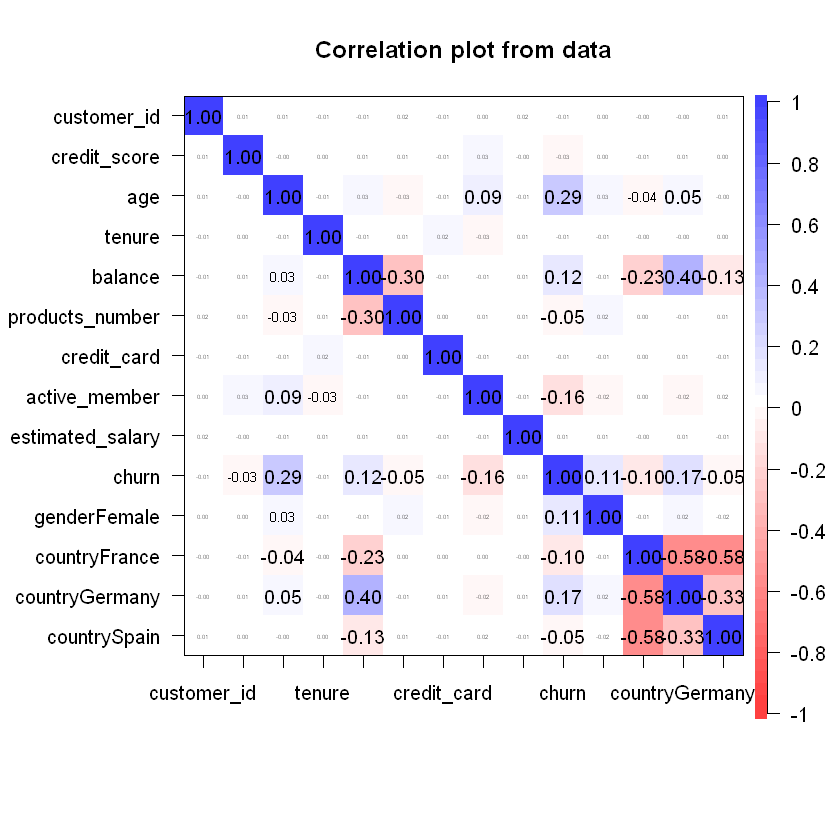

In [87]:
corPlot(df_new)

# 4: Recommendations

Based on your analysis, develop 3 recommendations that will help EBI to better manage customer churn. Explain the rationale behind those 3 recommendations. • EBI has formulated a list of a subset of its current customers (see the dataset “ebi_exp_customers.csv” to answer this question) and would like to use your prediction model to take proactive measures to retain these customers. Specifically, the bank would target the customers (say, via telemarketing) who have high likelihood of churn. • Use your prediction model to predict the likelihood of churn for each customer in the dataset. • Suppose that the value of retaining a customer is €5 while the cost incurred by the bank to avoid a customer from churning is €1. How many and which customers from the dataset (“ebi_exp_customers.csv”) would you recommend the bank to target to maximize the total expected profit from this proactive targeting experiment? How would your answer change if the value of retaining a customer goes up to €10? Explain your computation

In [99]:
df_2 <- read.csv("ebi_exp_customers.csv")
head(df_2)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,15575430,579,France,Female,33,1,118392.8,1,1,1,157564.75,0
2,15793890,728,France,Female,59,4,0.0,1,1,1,163365.85,1
3,15701166,660,France,Male,40,5,131754.1,2,1,1,38761.61,0
4,15624677,543,Germany,Female,37,3,122304.6,2,0,0,33998.70,0
5,15586264,572,France,Male,43,2,140432.0,1,1,0,26450.57,1
6,15600991,694,Germany,Male,31,6,109052.6,2,1,1,19448.93,1
